In [1]:

import sys
from pathlib import Path

In [2]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset

# Xử lý dữ liệu

## Lấy dữ liệu

Lấy dữ liệu từ file CSV

In [3]:
# Lấy dữ liệu từ nguồn sẵn có
import sys
import os
import talib as ta
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')  # Thêm đường dẫn gốc để import module

import pandas as pd
from data.data_processor.feature_engineer import engineer_stat as es
from data.split_data.split import split_data_two_parts
from environments.stock_trading_env.mdp import StockTradingMDP as stockMDP
from agents.d_sarsa.d_sarsa import train_deep_sarsa

# Định nghĩa đường dẫn gốc
base_path = 'd:\\NCKH\\SARSA_FinancialRL'

# Lấy dữ liệu tạm từ nguồn sẵn có
csv_path = os.path.join(base_path, 'data', 'data_storer', 'data_research', 'ACB_data.csv')
df = pd.read_csv(csv_path)
df

,time,open,high,low,close,volume
0,13/06/2012,3.58,3.61,3.58,3.61,289700
1,14/06/2012,3.60,3.61,3.58,3.58,294900
2,15/06/2012,3.58,3.60,3.58,3.58,180600
3,18/06/2012,3.58,3.63,3.58,3.61,129000
4,19/06/2012,3.61,3.63,3.60,3.61,402200
...,...,...,...,...,...,...
3128,25/12/2024,20.89,21.39,20.85,21.26,9518178
3129,26/12/2024,21.26,21.35,21.22,21.35,5583577
3130,27/12/2024,21.39,21.47,21.31,21.35,7694895
3131,30/12/2024,21.18,21.43,21.18,21.22,5004572


## Tính toán các chỉ báo kĩ thuật

In [4]:
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time').reset_index(drop=True)

# Gọi hàm với start_date và config tùy chỉnh
start_date = pd.to_datetime('01-01-2013', format='%d-%m-%Y')
price_history = es.add_technical_indicators(
    df, 
    start_date=start_date
)
# df_with_indicators giờ đã có các cột chỉ số, gắn vào df gốc của bạn
price_history

C:\Users\Admin\AppData\Local\Temp\ipykernel_28028\1549584949.py:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['time'] = pd.to_datetime(df['time'])


,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
0,02/01/2013,2.28,2.44,2.28,2.42,2578600,0.055972,73.052093,120.776420,44.021348
1,03/01/2013,2.45,2.49,2.34,2.38,1967200,0.059969,66.884624,133.797370,45.756108
2,04/01/2013,2.37,2.41,2.34,2.41,1170100,0.064810,68.998607,118.387909,47.366957
3,07/01/2013,2.38,2.45,2.38,2.41,1355700,0.067864,68.998607,139.004469,49.090718
4,08/01/2013,2.39,2.45,2.37,2.42,2180000,0.070282,69.745251,130.969966,50.367981
...,...,...,...,...,...,...,...,...,...,...
2986,25/12/2024,20.89,21.39,20.85,21.26,9518178,0.001988,58.521336,57.366264,13.491160
2987,26/12/2024,21.26,21.35,21.22,21.35,5583577,0.030857,60.704835,103.700635,13.890829
2988,27/12/2024,21.39,21.47,21.31,21.35,7694895,0.053123,60.704835,114.227950,14.698448
2989,30/12/2024,21.18,21.43,21.18,21.22,5004572,0.059592,55.785361,68.597285,14.724228


## Chia dữ liệu

In [5]:
# Chia dữ liệu theo khoảng thời gian cụ thể
price_history['time'] = pd.to_datetime(price_history['time'], format='%d/%m/%Y')

# Good period
good_train_ACB = price_history[(price_history['time'] >= '2013-01-01') & (price_history['time'] <= '2018-12-31')]
good_test_ACB = price_history[(price_history['time'] >= '2019-01-01') & (price_history['time'] <= '2021-12-31')]

# Bad period
bad_train_ACB = price_history[(price_history['time'] >= '2013-01-01') & (price_history['time'] <= '2021-12-31')]
bad_test_ACB = price_history[(price_history['time'] >= '2022-01-01') & (price_history['time'] <= '2023-12-31')]

print(f"Good Train ACB: {len(good_train_ACB)} rows")
good_train_ACB
print(f"Good Test ACB: {len(good_test_ACB)} rows")
good_test_ACB
print(f"Bad Train ACB: {len(bad_train_ACB)} rows")
bad_train_ACB
print(f"Bad Test ACB: {len(bad_test_ACB)} rows")
bad_test_ACB




Good Train ACB: 1496 rows
Good Test ACB: 747 rows
Bad Train ACB: 2243 rows
Bad Test ACB: 498 rows


,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
2243,2022-01-04,16.32,16.32,16.06,16.13,4555000,0.101631,63.020958,201.751229,13.985882
2244,2022-01-05,16.11,16.11,15.78,15.80,5934500,0.095704,53.030812,91.607565,13.486436
2245,2022-01-06,15.71,15.95,15.52,15.83,5673700,0.092362,53.748612,40.341578,12.895065
2246,2022-01-07,15.90,15.92,15.62,15.62,3323800,0.071940,48.196150,20.820358,12.345935
2247,2022-01-10,15.48,15.66,15.45,15.48,5693200,0.043951,44.868388,-43.505857,12.374926
...,...,...,...,...,...,...,...,...,...,...
2736,2023-12-25,16.32,16.46,16.28,16.39,7586810,0.179923,67.818142,146.324609,18.776270
2737,2023-12-26,16.42,16.42,16.32,16.32,5731233,0.186499,64.639208,120.599526,20.247209
2738,2023-12-27,16.28,16.42,16.28,16.35,4869398,0.191919,65.388015,105.073950,21.269247
2739,2023-12-28,16.35,16.81,16.35,16.67,10526964,0.219506,72.160185,144.859900,23.462380


In [6]:
# Lưu các biến DataFrame thành file CSV
import os

# Thư mục train
train_dir = r'D:\nckh\SARSA_FinancialRL\data\data_storer\data_research\train'
os.makedirs(train_dir, exist_ok=True)
good_train_ACB.to_csv(os.path.join(train_dir, 'good_train_ACB.csv'), index=False)
bad_train_ACB.to_csv(os.path.join(train_dir, 'bad_train_ACB.csv'), index=False)

# Thư mục test
test_dir = r'D:\nckh\SARSA_FinancialRL\data\data_storer\data_research\test'
os.makedirs(test_dir, exist_ok=True)
good_test_ACB.to_csv(os.path.join(test_dir, 'good_test_ACB.csv'), index=False)
bad_test_ACB.to_csv(os.path.join(test_dir, 'bad_test_ACB.csv'), index=False)

print("Đã lưu tất cả file CSV thành công!")


Đã lưu tất cả file CSV thành công!


# Triển khai chính sách ngẫu nhiên
làm tiên chuẩn (baseline) để so sánh với kết quả với kết quả của ba agent sắp tới.

Chính sách này không học hỏi gì, chỉ chọn hành động ngẫu nhiên đều đặn, như tung xúc xắc để quyết định mua/bán.

Chạy trên tập test

In [8]:
train = good_train_ACB
test = good_test_ACB
# Định nghĩa danh sách hành động (A) - cần thiết cho pi_random
balance_init = 1000  # số dư ban đầu
k = 5  # số cổ phiếu tối đa
min_balance = -100  # ngưỡng số dư tối thiểu
A = [a for a in range(-k, k + 1, 1)]  # hành động: -5 đến +5

# Tạo instance của StockTradingMDP
mdp = stockMDP(balance_init=balance_init, k=k, min_balance=min_balance)

# policy
def pi_random(s, greedy=False, eps=0.2):
    return np.random.choice(A) # random policy (uniform distributed)

profits = list()
for rep in tqdm(range(20)):
    profit = mdp.interact_test(
        pi=pi_random,  # chính sách (hàm pi_random)
        train_series=train,  # DataFrame train (từ cell chia dữ liệu)
        test_series=test,  # DataFrame test (từ cell chia dữ liệu)
        series_name='test',  # chạy trên tập test
        verbose=False  # không hiển thị biểu đồ (chỉ thu thập dữ liệu)
    )
    profits.append(profit)
print("Avg Profit", np.mean(profits))
print('STD Profit', np.std(profits))

100%|██████████| 20/20 [00:01<00:00, 12.80it/s]

Avg Profit 533.0417434999997
STD Profit 331.7492444778927


In [9]:
good_train_ACB

,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
0,2013-01-02,2.28,2.44,2.28,2.42,2578600,0.055972,73.052093,120.776420,44.021348
1,2013-01-03,2.45,2.49,2.34,2.38,1967200,0.059969,66.884624,133.797370,45.756108
2,2013-01-04,2.37,2.41,2.34,2.41,1170100,0.064810,68.998607,118.387909,47.366957
3,2013-01-07,2.38,2.45,2.38,2.41,1355700,0.067864,68.998607,139.004469,49.090718
4,2013-01-08,2.39,2.45,2.37,2.42,2180000,0.070282,69.745251,130.969966,50.367981
...,...,...,...,...,...,...,...,...,...,...
1491,2018-12-24,6.22,6.55,6.22,6.44,2237789,-0.021293,38.875525,-107.671139,30.021270
1492,2018-12-25,6.39,6.39,6.24,6.39,4310235,-0.037374,36.768561,-129.364279,29.583996
1493,2018-12-26,5.77,6.44,5.77,6.37,1518665,-0.051142,35.929721,-177.477477,30.268892
1494,2018-12-27,6.53,6.59,6.44,6.53,2409678,-0.048582,46.454244,-49.116162,30.263401


In [10]:
good_test_ACB

,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
1496,2019-01-02,6.57,6.57,6.42,6.48,1103106,-0.045019,44.187396,-56.914563,30.302830
1497,2019-01-03,5.84,6.46,5.84,6.24,1956382,-0.065365,34.867843,-160.030628,31.508307
1498,2019-01-04,6.22,6.33,6.13,6.28,2771983,-0.077369,37.243527,-122.215877,32.627679
1499,2019-01-07,6.42,6.42,6.33,6.37,1305819,-0.078713,42.339625,-68.136273,33.239148
1500,2019-01-08,6.97,6.97,6.33,6.33,846226,-0.082060,40.755577,6.674082,31.676051
...,...,...,...,...,...,...,...,...,...,...
2238,2021-12-27,15.62,15.62,15.43,15.55,2459500,-0.044776,50.425746,14.948794,14.472513
2239,2021-12-28,15.55,15.83,15.50,15.78,3477400,-0.018337,56.163825,104.018311,13.551121
2240,2021-12-29,15.88,16.04,15.80,15.85,3817200,0.008170,57.766063,181.603774,13.429091
2241,2021-12-30,15.80,15.95,15.71,15.90,1819600,0.032833,58.921032,146.247973,12.948745


# Huấn luyện agent Deep - SARSA với tình huống tốt


In [23]:
"""
shared_config = {
    'episodes': 30,         # Original episodes
    'gamma': 0.6,          # Original gamma
    'alpha': 0.7,           # Original alpha
    'epsilon_start': 0.8,   # Original epsilon_start
    'epsilon_min': 0.2,     # Original epsilon_min
    'epsilon_decay': 0.9,  # Chỉnh nhẹ từ 0.98 xuống 0.95 để khám phá chậm hơn trên FPT
    'nn_epochs': 10,        # Original nn_epochs
    'nn_lr': 1e-5,          # Original nn_lr
    'enabled_agents': [1, 1,1]  # [SARSA, DQN, PG]: 1 để bật, 0 để tắt
}
"""
shared_config = {
    'episodes': 35,         # Original episodes
    'gamma': 0.95,          # Original gamma
    'alpha': 0.6,           # Original alpha
    'epsilon_start': 0.9,   # Original epsilon_start
    'epsilon_min': 0.1,     # Original epsilon_min
    'epsilon_decay': 0.95,  # Chỉnh nhẹ từ 0.98 xuống 0.95 để khám phá chậm hơn trên FPT
    'nn_epochs': 10,        # Original nn_epochs
    'nn_lr': 1e-5,          # Original nn_lr
    'enabled_agents': [1, 1,1]  # [SARSA, DQN, PG]: 1 để bật, 0 để tắt
}

"""'episodes': 35, 'gamma': 0.8369349814523732, 'alpha': 0.5680671593345815, 'epsilon_start': 0.9540941536350933, 'epsilon_min': 0.19785221090168595, 'epsilon_decay': 0.9489652036913004, 'nn_epochs': 32, 'nn_lr': 0.0002990739041169814}"""

"'episodes': 35, 'gamma': 0.8369349814523732, 'alpha': 0.5680671593345815, 'epsilon_start': 0.9540941536350933, 'epsilon_min': 0.19785221090168595, 'epsilon_decay': 0.9489652036913004, 'nn_epochs': 32, 'nn_lr': 0.0002990739041169814}"


RUNNING DEEP SARSA EXPERIMENTS


Running Deep SARSA 20 times: 100%|██████████| 20/20 [10:20<00:00, 31.03s/it]



RUNNING DQN EXPERIMENTS


Running DQN 20 times: 100%|██████████| 20/20 [05:47<00:00, 17.35s/it]



RUNNING POLICY GRADIENT EXPERIMENTS


Running Policy Gradient 20 times: 100%|██████████| 20/20 [12:20<00:00, 37.03s/it]




EXPERIMENT SUMMARY

Deep SARSA:
  • Average Final Profit: $906.28 ± $612.15
  • ROI: 90.63%
  • Annual Return Rate: 8.40%
  • Best Training Profit: $952.89
  • Training Stability (std): $632.10

DQN:
  • Average Final Profit: $611.11 ± $686.79
  • ROI: 61.11%
  • Annual Return Rate: 6.14%
  • Best Training Profit: $611.20
  • Training Stability (std): $692.97

Policy Gradient:
  • Average Final Profit: $767.39 ± $791.76
  • ROI: 76.74%
  • Annual Return Rate: 7.38%


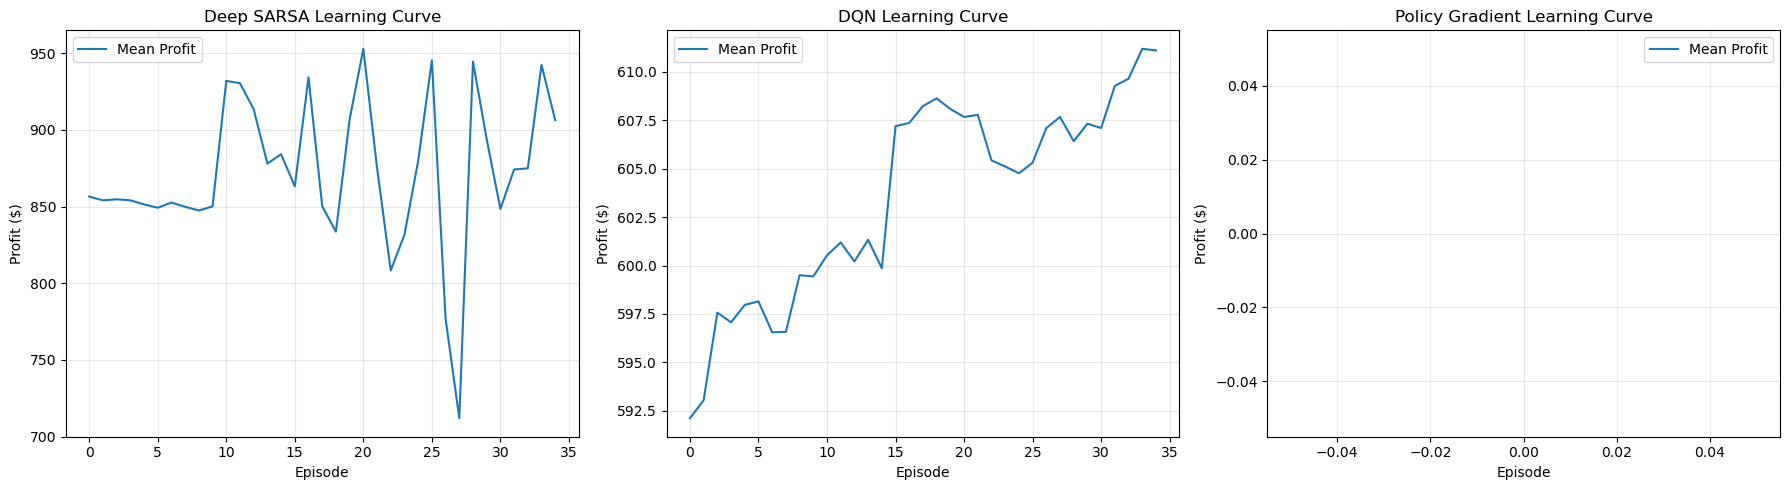


FINAL RESULTS SUMMARY

Deep SARSA:
  • Average Final Profit: $906.28 ± $612.15
  • Best Profit: $1604.85
  • Worst Profit: $-30.18
  • Peak Training Profit: $952.89
  • ROI: 90.63%
  • Annual Return Rate: 24.04%
  • Total Return Rate: 90.63%

DQN:
  • Average Final Profit: $611.11 ± $686.79
  • Best Profit: $1615.03
  • Worst Profit: $0.00
  • Peak Training Profit: $611.20
  • ROI: 61.11%
  • Annual Return Rate: 17.26%
  • Total Return Rate: 61.11%

Policy Gradient:
  • Average Final Profit: $767.39 ± $791.76
  • Best Profit: $2055.30
  • Worst Profit: $-26.80
  • ROI: 76.74%
  • Annual Return Rate: 20.94%
  • Total Return Rate: 76.74%

Random Policy Baseline:
  • Average Profit: $37.13 ± $41.33
  • Annual Return Rate: 1.22%
  • Total Return Rate: 3.71%


In [24]:
# Thêm đường dẫn gốc để import module
import sys
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')

# Import run_experiments từ agents.run
from agents.run import run_experiments

# Định nghĩa shared_config với original settings từ paper, chỉnh nhẹ epsilon_decay xuống 0.95 để phù hợp với FPT data


# Chuyển lại Good Period
train = good_train_ACB
test = good_test_ACB

# Chạy thử nghiệm cho agent được bật với cùng siêu tham số
results = run_experiments(mdp, train, test, shared_config, num_runs=20)
results_good = results.copy()

# Hiển thị kết quả
import matplotlib.pyplot as plt

# Vẽ learning curves cho từng agent
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

agents = ['sarsa', 'dqn', 'pg']
titles = ['Deep SARSA', 'DQN', 'Policy Gradient']

for i, (agent, title) in enumerate(zip(agents, titles)):
    if agent in results:
        res = results[agent]
        mean_curve = res['learning_curve']
        
        axes[i].plot(mean_curve, label='Mean Profit')
        axes[i].set_title(f'{title} Learning Curve')
        axes[i].set_xlabel('Episode')
        axes[i].set_ylabel('Profit ($)')
        axes[i].legend()
        axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Định nghĩa hàm tính Annual Return Rate
def agent_annual_return(initial_capital, final_portfolio, start_date, end_date):
    total_return = (final_portfolio / initial_capital) - 1
    years = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days / 365.25
    if years <= 0: return 0, 0
    annual = (1 + total_return) ** (1 / years) - 1
    return annual * 100, total_return * 100

# Xác định start_date và end_date từ test_series
start_date = test.iloc[0]['time']
end_date = test.iloc[-1]['time']

# In tóm tắt kết quả
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

for agent in agents:
    if agent in results:
        res = results[agent]
        print(f"\n{res['agent']}:")
        print(f"  • Average Final Profit: ${res['final_profit']:.2f} ± ${res['std_final_profit']:.2f}")
        print(f"  • Best Profit: ${np.max(res['all_final_profits']):.2f}")
        print(f"  • Worst Profit: ${np.min(res['all_final_profits']):.2f}")
        if len(res['learning_curve']) > 0:
            print(f"  • Peak Training Profit: ${np.max(res['learning_curve']):.2f}")
        
        print(f"  • ROI: {res['roi']:.2f}%")
        
        # Tính Annual Return Rate
        final_portfolio = 1000 + res['final_profit']
        annual_rate, total_rate = agent_annual_return(1000, final_portfolio, start_date, end_date)
        print(f"  • Annual Return Rate: {annual_rate:.2f}%")
        print(f"  • Total Return Rate: {total_rate:.2f}%")

# So sánh với baseline (random policy)
print(f"\nRandom Policy Baseline:")
print(f"  • Average Profit: ${np.mean(profits):.2f} ± ${np.std(profits):.2f}")

# Tính Annual Return Rate cho baseline
baseline_final_portfolio = 1000 + np.mean(profits)
baseline_annual_rate, baseline_total_rate = agent_annual_return(1000, baseline_final_portfolio, start_date, end_date)
print(f"  • Annual Return Rate: {baseline_annual_rate:.2f}%")
print(f"  • Total Return Rate: {baseline_total_rate:.2f}%")

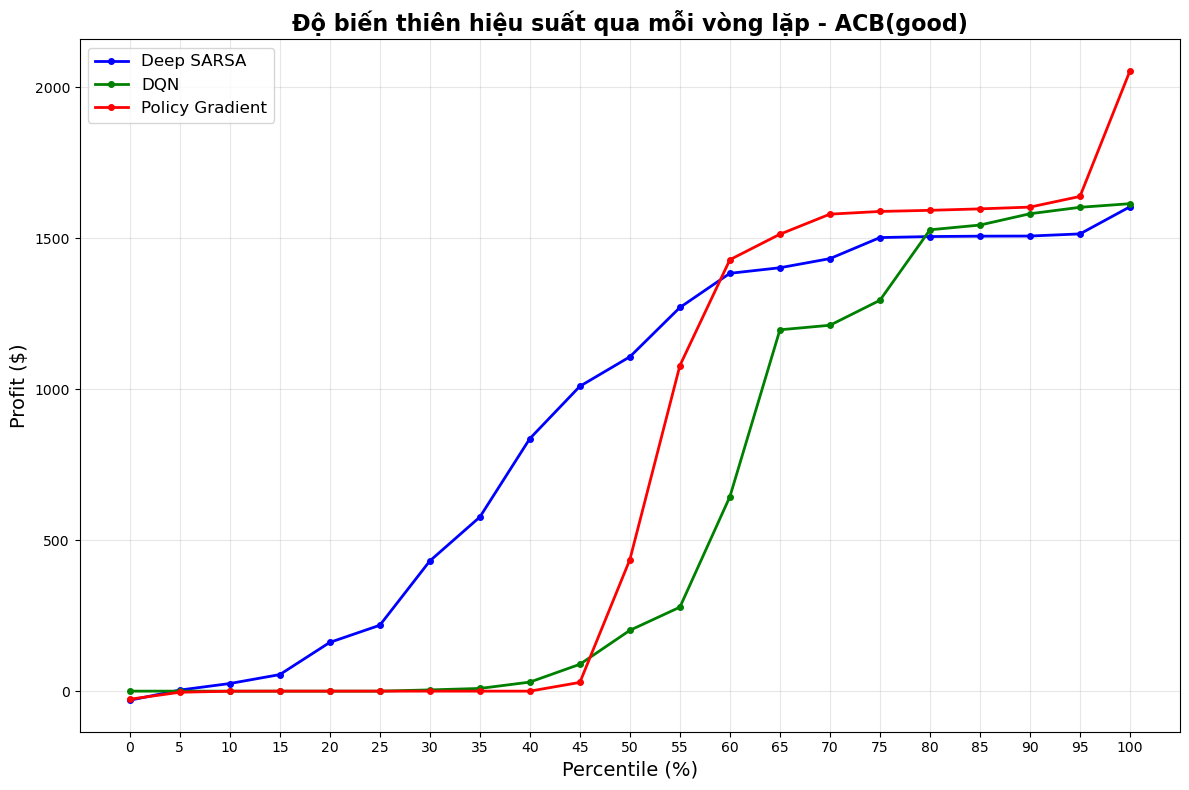

In [25]:
# Vẽ biểu đồ Percentiles Over Repeated Experiments
import matplotlib.pyplot as plt
import numpy as np

# Danh sách percentiles để vẽ (từ 0% đến 100% với bước 5%)
percentile_levels = np.arange(0, 101, 5)

# Tạo figure
plt.figure(figsize=(12, 8))

# Vẽ cho từng agent
colors = ['blue', 'green', 'red']
agents = ['sarsa', 'dqn', 'pg']
agent_names = ['Deep SARSA', 'DQN', 'Policy Gradient']

for i, (agent, name) in enumerate(zip(agents, agent_names)):
    if agent in results:
        profits = results[agent]['all_final_profits']
        sorted_profits = np.sort(profits)
        percentile_values = np.percentile(sorted_profits, percentile_levels)
        plt.plot(percentile_levels, percentile_values, 
                color=colors[i], marker='o', linestyle='-', 
                label=name, linewidth=2, markersize=4)

# Thiết lập biểu đồ
plt.title('Độ biến thiên hiệu suất qua mỗi vòng lặp - ACB(good)', fontsize=16, fontweight='bold')
plt.xlabel('Percentile (%)', fontsize=14)
plt.ylabel('Profit ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(percentile_levels)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

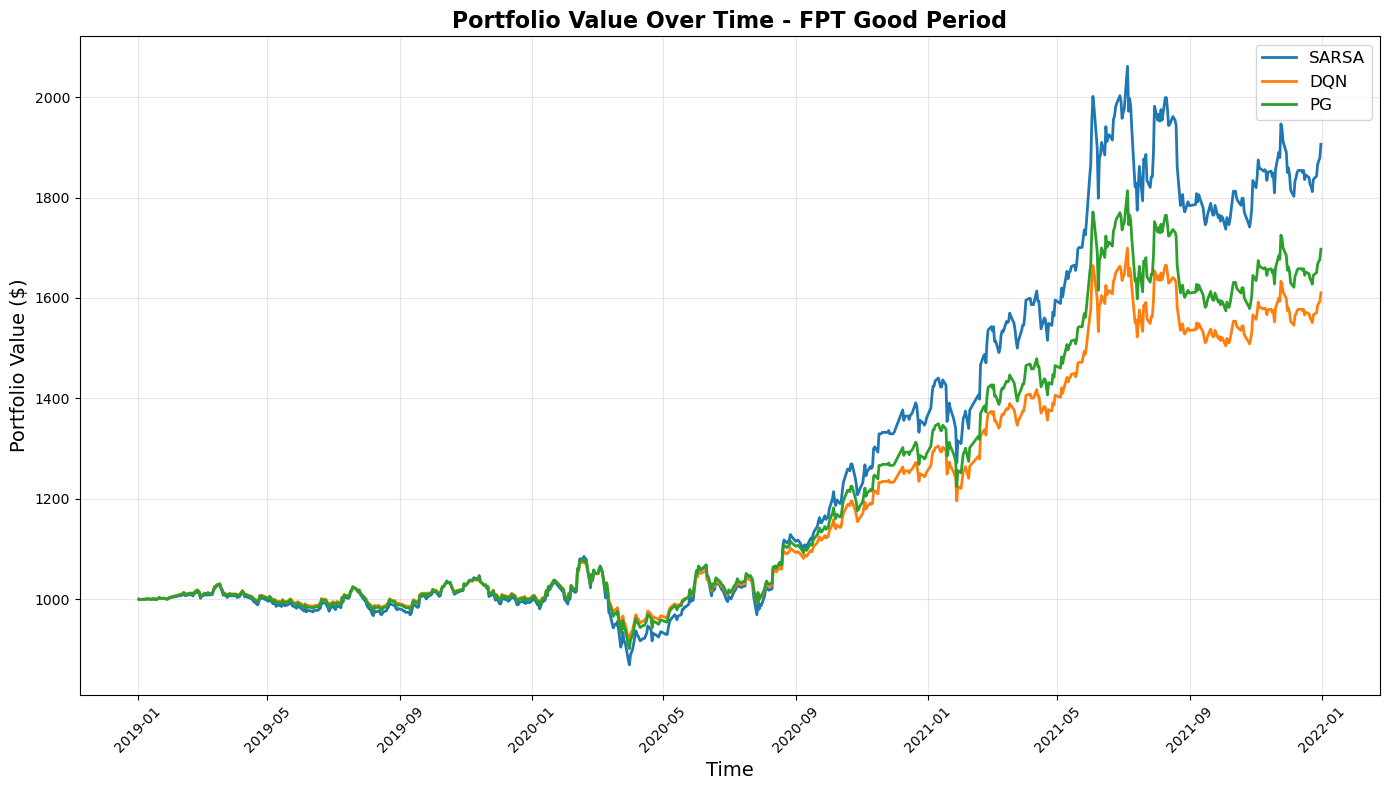

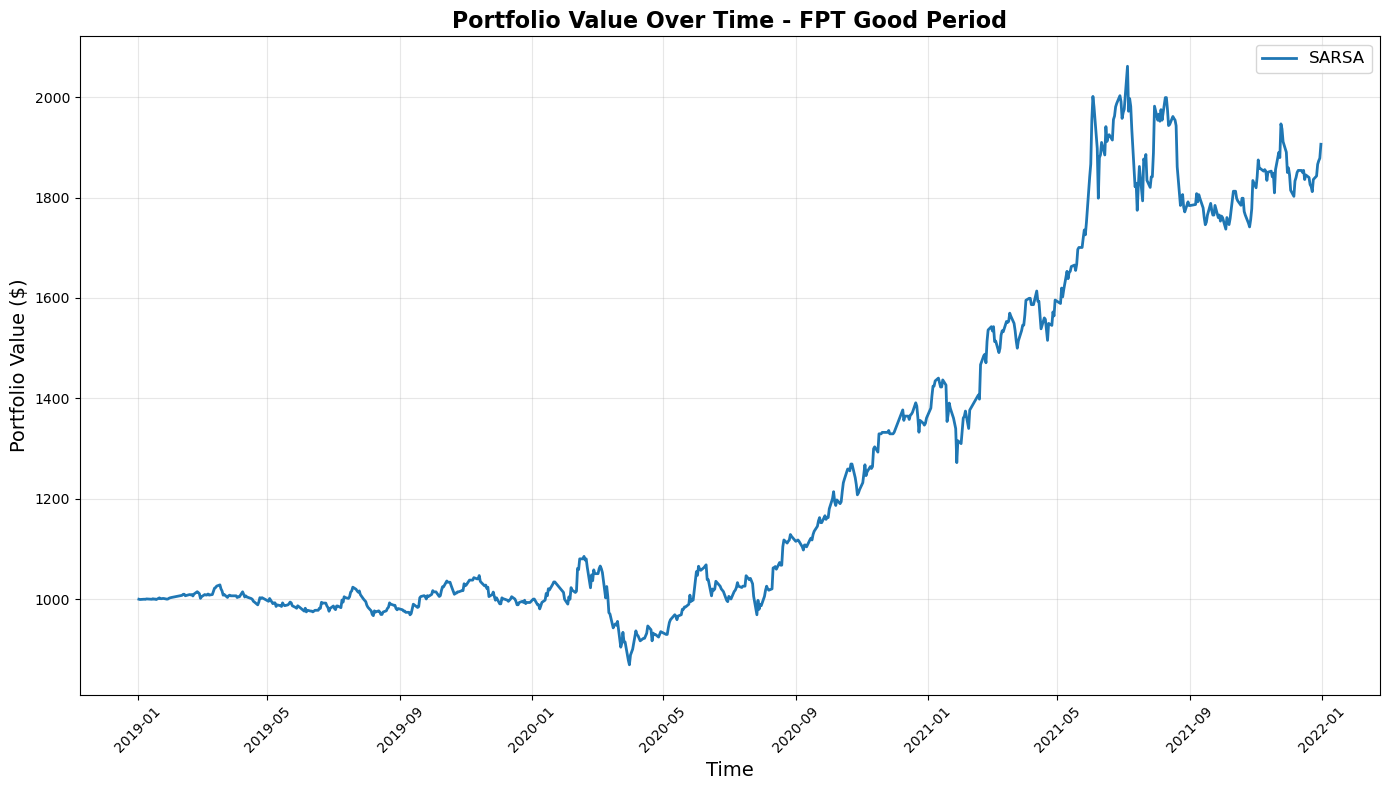

In [26]:
# Vẽ đồ thị
portfolio_histories = {}
for agent_name in ['sarsa', 'dqn', 'pg']:
    if agent_name in results:
        portfolio_histories[agent_name] = results[agent_name]['portfolio_history']

plt.figure(figsize=(14, 8))
for agent, port in portfolio_histories.items():
    # Cắt portfolio_history để khớp với len(test['time'])
    plt.plot(test['time'], port[1:], label=agent.upper(), linewidth=2)

plt.title('Portfolio Value Over Time - FPT Good Period', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Vẽ đồ thị
portfolio_histories = {}
for agent_name in ['sarsa']:
    if agent_name in results:
        portfolio_histories[agent_name] = results[agent_name]['portfolio_history']

plt.figure(figsize=(14, 8))
for agent, port in portfolio_histories.items():
    # Cắt portfolio_history để khớp với len(test['time'])
    plt.plot(test['time'], port[1:], label=agent.upper(), linewidth=2)

plt.title('Portfolio Value Over Time - FPT Good Period', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
import os

models_dir = r'D:\nckh\SARSA_FinancialRL\models'

os.makedirs(models_dir, exist_ok=True)

# Save trained models for ACB good period
if 'sarsa' in results:
    torch.save(results['sarsa']['trained_agent'].state_dict(), os.path.join(models_dir, 'sarsa_good_acb.pth'))
    print("Deep SARSA model saved.")

if 'dqn' in results:
    results['dqn']['trained_agent'].save(os.path.join(models_dir, 'dqn_good_acb.pth'))
    print("DQN model saved.")

if 'pg' in results:
    results['pg']['trained_agent'].save_model(os.path.join(models_dir, 'pg_good_acb.pth'))
    print("Policy Gradient model saved.")

print("All models for ACB good period saved successfully!")

Deep SARSA model saved.
DQN model saved.
Policy Gradient model saved.
All models for ACB good period saved successfully!


In [30]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
import os

# Đảm bảo thư mục tồn tại
results_dir = r'D:\nckh\SARSA_FinancialRL\application\results'
os.makedirs(results_dir, exist_ok=True)

# Tạo PDF
pdf_path = os.path.join(results_dir, 'ACB_good.pdf')
doc = SimpleDocTemplate(pdf_path, pagesize=letter)
elements = []
styles = getSampleStyleSheet()

# Title
elements.append(Paragraph("Training Results for ACB Good Period", styles['Title']))
elements.append(Spacer(1, 12))

# Hyperparameters
elements.append(Paragraph("Hyperparameters:", styles['Heading2']))
hp_text = f"""
Episodes: {shared_config['episodes']}
Gamma: {shared_config['gamma']}
Alpha: {shared_config['alpha']}
Epsilon Start: {shared_config['epsilon_start']}
Epsilon Min: {shared_config['epsilon_min']}
Epsilon Decay: {shared_config['epsilon_decay']}
NN Epochs: {shared_config['nn_epochs']}
NN LR: {shared_config['nn_lr']}
Enabled Agents: {shared_config['enabled_agents']}
"""
elements.append(Paragraph(hp_text, styles['Normal']))
elements.append(Spacer(1, 12))

# Results Table
elements.append(Paragraph("Training Results:", styles['Heading2']))

# Tạo data cho table
data = [['Agent', 'Average Final Profit', 'Best Profit', 'Worst Profit', 'Peak Training Profit', 'ROI', 'Annual Return Rate', 'Total Return Rate']]
for agent in agents:
    if agent in results:
        res = results[agent]
        avg_profit = f"${res['final_profit']:.2f} ± ${res['std_final_profit']:.2f}"
        best = f"${np.max(res['all_final_profits']):.2f}"
        worst = f"${np.min(res['all_final_profits']):.2f}"
        peak = f"${np.max(res['learning_curve']):.2f}" if len(res['learning_curve']) > 0 else 'N/A'
        roi = f"{res['roi']:.2f}%"
        final_portfolio = 1000 + res['final_profit']
        annual_rate, total_rate = agent_annual_return(1000, final_portfolio, start_date, end_date)
        annual = f"{annual_rate:.2f}%"
        total = f"{total_rate:.2f}%"
        data.append([res['agent'], avg_profit, best, worst, peak, roi, annual, total])

# Baseline
baseline_avg = f"${np.mean(profits):.2f} ± ${np.std(profits):.2f}"
baseline_final_portfolio = 1000 + np.mean(profits)
baseline_annual_rate, baseline_total_rate = agent_annual_return(1000, baseline_final_portfolio, start_date, end_date)
data.append(['Random Policy Baseline', baseline_avg, 'N/A', 'N/A', 'N/A', f"{((np.mean(profits)/1000)*100):.2f}%", f"{baseline_annual_rate:.2f}%", f"{baseline_total_rate:.2f}%"])

table = Table(data)
table.setStyle(TableStyle([
    ('BACKGROUND', (0,0), (-1,0), colors.grey),
    ('TEXTCOLOR', (0,0), (-1,0), colors.whitesmoke),
    ('ALIGN', (0,0), (-1,-1), 'CENTER'),
    ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
    ('BOTTOMPADDING', (0,0), (-1,0), 12),
    ('BACKGROUND', (0,1), (-1,-1), colors.beige),
    ('GRID', (0,0), (-1,-1), 1, colors.black)
]))
elements.append(table)
elements.append(Spacer(1, 12))

# Biểu đồ Learning Curves
elements.append(Paragraph("Learning Curves:", styles['Heading2']))
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (agent, title) in enumerate(zip(agents, titles)):
    if agent in results:
        res = results[agent]
        mean_curve = res['learning_curve']
        axes[i].plot(mean_curve, label='Mean Profit')
        axes[i].set_title(f'{title} Learning Curve')
        axes[i].set_xlabel('Episode')
        axes[i].set_ylabel('Profit ($)')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
plt.tight_layout()
learning_curve_path = os.path.join(results_dir, 'learning_curves.png')
plt.savefig(learning_curve_path)
plt.close()
elements.append(Image(learning_curve_path, width=500, height=300))

# Biểu đồ Percentiles
elements.append(Paragraph("Profit Percentiles:", styles['Heading2']))
agent_names = titles
plt.figure(figsize=(12, 8))
color_list = ['blue', 'green', 'red']
for i, (agent, name) in enumerate(zip(agents, agent_names)):
    if agent in results:
        agent_profits = results[agent]['all_final_profits']
        sorted_profits = np.sort(agent_profits)
        percentile_values = np.percentile(sorted_profits, percentile_levels)
        plt.plot(percentile_levels, percentile_values, color=color_list[i], marker='o', linestyle='-', label=name, linewidth=2, markersize=4)
plt.title('Độ biến thiên hiệu suất qua mỗi vòng lặp - ACB', fontsize=16, fontweight='bold')
plt.xlabel('Percentile (%)', fontsize=14)
plt.ylabel('Profit ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(percentile_levels)
plt.tight_layout()
percentile_path = os.path.join(results_dir, 'percentiles.png')
plt.savefig(percentile_path)
plt.close()
elements.append(Image(percentile_path, width=500, height=400))

# Biểu đồ Portfolio Value Over Time
elements.append(Paragraph("Portfolio Value Over Time:", styles['Heading2']))
portfolio_histories = {}
for agent_name in ['sarsa', 'dqn', 'pg']:
    if agent_name in results:
        portfolio_histories[agent_name] = results[agent_name]['portfolio_history']

plt.figure(figsize=(14, 8))
for agent, port in portfolio_histories.items():
    plt.plot(test['time'], port[1:], label=agent.upper(), linewidth=2)
plt.title('Portfolio Value Over Time - ACB Good Period', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
portfolio_path = os.path.join(results_dir, 'portfolio_value_good.png')
plt.savefig(portfolio_path)
plt.close()
elements.append(Image(portfolio_path, width=500, height=400))

# Build PDF
doc.build(elements)
print(f"PDF saved to {pdf_path}")

PDF saved to D:\nckh\SARSA_FinancialRL\application\results\ACB_good.pdf


In [29]:
bad_train_ACB

,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
0,2013-01-02,2.28,2.44,2.28,2.42,2578600,0.055972,73.052093,120.776420,44.021348
1,2013-01-03,2.45,2.49,2.34,2.38,1967200,0.059969,66.884624,133.797370,45.756108
2,2013-01-04,2.37,2.41,2.34,2.41,1170100,0.064810,68.998607,118.387909,47.366957
3,2013-01-07,2.38,2.45,2.38,2.41,1355700,0.067864,68.998607,139.004469,49.090718
4,2013-01-08,2.39,2.45,2.37,2.42,2180000,0.070282,69.745251,130.969966,50.367981
...,...,...,...,...,...,...,...,...,...,...
2238,2021-12-27,15.62,15.62,15.43,15.55,2459500,-0.044776,50.425746,14.948794,14.472513
2239,2021-12-28,15.55,15.83,15.50,15.78,3477400,-0.018337,56.163825,104.018311,13.551121
2240,2021-12-29,15.88,16.04,15.80,15.85,3817200,0.008170,57.766063,181.603774,13.429091
2241,2021-12-30,15.80,15.95,15.71,15.90,1819600,0.032833,58.921032,146.247973,12.948745


In [17]:
bad_test_ACB

,time,open,high,low,close,volume,MACD,RSI,CCI,ADX
2243,2022-01-04,16.32,16.32,16.06,16.13,4555000,0.101631,63.020958,201.751229,13.985882
2244,2022-01-05,16.11,16.11,15.78,15.80,5934500,0.095704,53.030812,91.607565,13.486436
2245,2022-01-06,15.71,15.95,15.52,15.83,5673700,0.092362,53.748612,40.341578,12.895065
2246,2022-01-07,15.90,15.92,15.62,15.62,3323800,0.071940,48.196150,20.820358,12.345935
2247,2022-01-10,15.48,15.66,15.45,15.48,5693200,0.043951,44.868388,-43.505857,12.374926
...,...,...,...,...,...,...,...,...,...,...
2736,2023-12-25,16.32,16.46,16.28,16.39,7586810,0.179923,67.818142,146.324609,18.776270
2737,2023-12-26,16.42,16.42,16.32,16.32,5731233,0.186499,64.639208,120.599526,20.247209
2738,2023-12-27,16.28,16.42,16.28,16.35,4869398,0.191919,65.388015,105.073950,21.269247
2739,2023-12-28,16.35,16.81,16.35,16.67,10526964,0.219506,72.160185,144.859900,23.462380


# Huấn luyện trên trường hợp xấu 


RUNNING DEEP SARSA EXPERIMENTS


Running Deep SARSA 20 times: 100%|██████████| 20/20 [14:58<00:00, 44.90s/it]



RUNNING DQN EXPERIMENTS


Running DQN 20 times: 100%|██████████| 20/20 [07:16<00:00, 21.82s/it]



RUNNING POLICY GRADIENT EXPERIMENTS


Running Policy Gradient 20 times: 100%|██████████| 20/20 [18:11<00:00, 54.56s/it]




EXPERIMENT SUMMARY

Deep SARSA:
  • Average Final Profit: $49.80 ± $76.60
  • ROI: 4.98%
  • Annual Return Rate: 0.61%
  • Best Training Profit: $69.90
  • Training Stability (std): $61.30

DQN:
  • Average Final Profit: $33.10 ± $79.28
  • ROI: 3.31%
  • Annual Return Rate: 0.41%
  • Best Training Profit: $34.37
  • Training Stability (std): $67.11

Policy Gradient:
  • Average Final Profit: $42.02 ± $47.26
  • ROI: 4.20%
  • Annual Return Rate: 0.52%


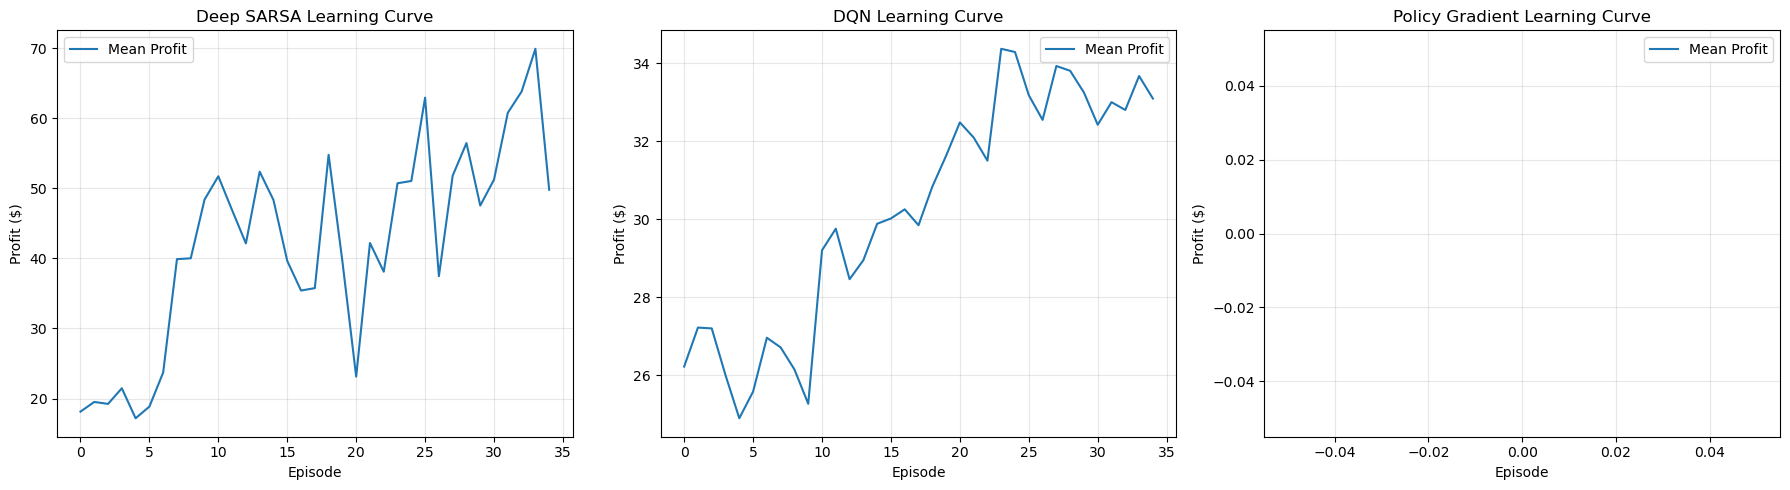


FINAL RESULTS SUMMARY

Deep SARSA:
  • Average Final Profit: $49.80 ± $76.60
  • Best Profit: $157.90
  • Worst Profit: $-73.18
  • Peak Training Profit: $69.90
  • ROI: 4.98%
  • Annual Return Rate: 2.48%
  • Total Return Rate: 4.98%

DQN:
  • Average Final Profit: $33.10 ± $79.28
  • Best Profit: $348.09
  • Worst Profit: $-32.05
  • Peak Training Profit: $34.37
  • ROI: 3.31%
  • Annual Return Rate: 1.66%
  • Total Return Rate: 3.31%

Policy Gradient:
  • Average Final Profit: $42.02 ± $47.26
  • Best Profit: $136.97
  • Worst Profit: $-29.78
  • ROI: 4.20%
  • Annual Return Rate: 2.10%
  • Total Return Rate: 4.20%

Random Policy Baseline:
  • Average Profit: $767.39 ± $791.76
  • Annual Return Rate: 33.28%
  • Total Return Rate: 76.74%


In [31]:
# Thêm đường dẫn gốc để import module
import sys
sys.path.append('d:\\NCKH\\SARSA_FinancialRL')

# Import run_experiments từ agents.run
from agents.run import run_experiments

# Định nghĩa shared_config với original settings từ paper, chỉnh nhẹ epsilon_decay xuống 0.95 để phù hợp với FPT data


# Chuyển lại Good Period
train = bad_train_ACB
test = bad_test_ACB

# Chạy thử nghiệm cho agent được bật với cùng siêu tham số
results = run_experiments(mdp, train, test, shared_config, num_runs=20)
results_good = results.copy()

# Hiển thị kết quả
import matplotlib.pyplot as plt

# Vẽ learning curves cho từng agent
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

agents = ['sarsa', 'dqn', 'pg']
titles = ['Deep SARSA', 'DQN', 'Policy Gradient']

for i, (agent, title) in enumerate(zip(agents, titles)):
    if agent in results:
        res = results[agent]
        mean_curve = res['learning_curve']
        
        axes[i].plot(mean_curve, label='Mean Profit')
        axes[i].set_title(f'{title} Learning Curve')
        axes[i].set_xlabel('Episode')
        axes[i].set_ylabel('Profit ($)')
        axes[i].legend()
        axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Định nghĩa hàm tính Annual Return Rate
def agent_annual_return(initial_capital, final_portfolio, start_date, end_date):
    total_return = (final_portfolio / initial_capital) - 1
    years = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days / 365.25
    if years <= 0: return 0, 0
    annual = (1 + total_return) ** (1 / years) - 1
    return annual * 100, total_return * 100

# Xác định start_date và end_date từ test_series
start_date = test.iloc[0]['time']
end_date = test.iloc[-1]['time']

# In tóm tắt kết quả
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)

for agent in agents:
    if agent in results:
        res = results[agent]
        print(f"\n{res['agent']}:")
        print(f"  • Average Final Profit: ${res['final_profit']:.2f} ± ${res['std_final_profit']:.2f}")
        print(f"  • Best Profit: ${np.max(res['all_final_profits']):.2f}")
        print(f"  • Worst Profit: ${np.min(res['all_final_profits']):.2f}")
        if len(res['learning_curve']) > 0:
            print(f"  • Peak Training Profit: ${np.max(res['learning_curve']):.2f}")
        
        print(f"  • ROI: {res['roi']:.2f}%")
        
        # Tính Annual Return Rate
        final_portfolio = 1000 + res['final_profit']
        annual_rate, total_rate = agent_annual_return(1000, final_portfolio, start_date, end_date)
        print(f"  • Annual Return Rate: {annual_rate:.2f}%")
        print(f"  • Total Return Rate: {total_rate:.2f}%")

# So sánh với baseline (random policy)
print(f"\nRandom Policy Baseline:")
print(f"  • Average Profit: ${np.mean(profits):.2f} ± ${np.std(profits):.2f}")

# Tính Annual Return Rate cho baseline
baseline_final_portfolio = 1000 + np.mean(profits)
baseline_annual_rate, baseline_total_rate = agent_annual_return(1000, baseline_final_portfolio, start_date, end_date)
print(f"  • Annual Return Rate: {baseline_annual_rate:.2f}%")
print(f"  • Total Return Rate: {baseline_total_rate:.2f}%")

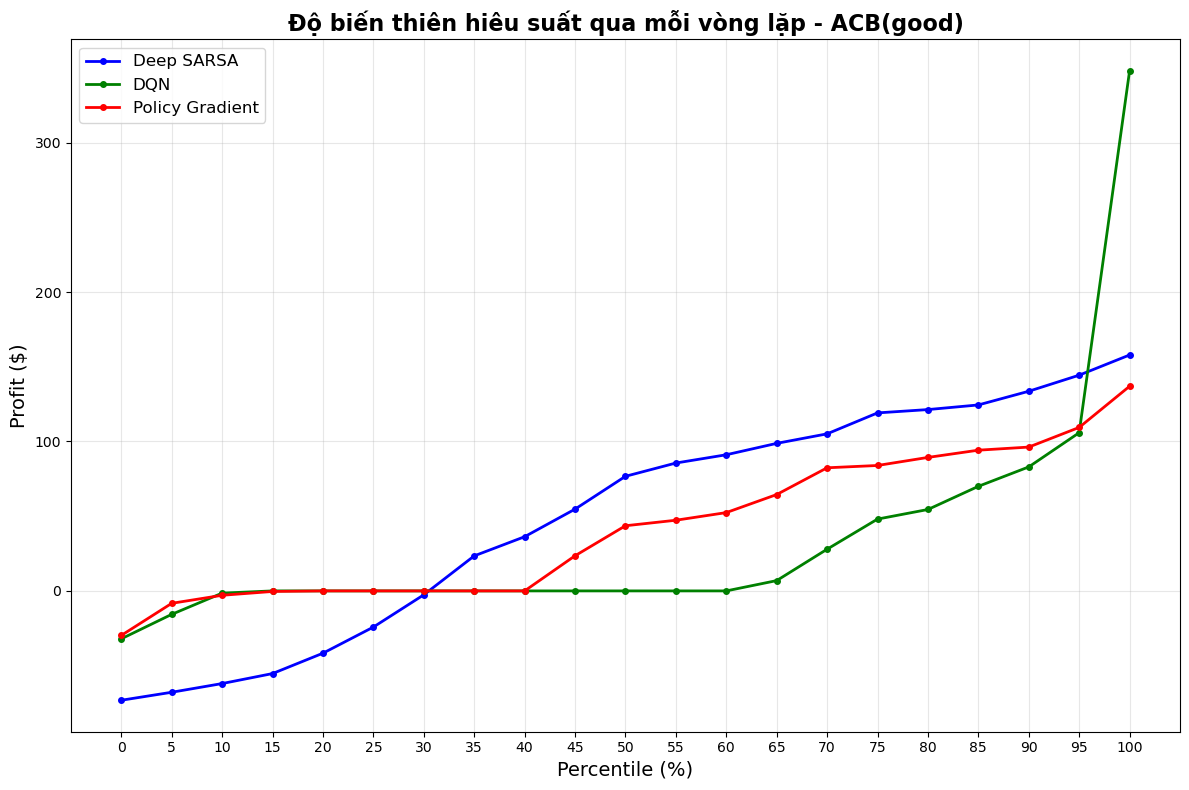

In [32]:
# Vẽ biểu đồ Percentiles Over Repeated Experiments
import matplotlib.pyplot as plt
import numpy as np

# Danh sách percentiles để vẽ (từ 0% đến 100% với bước 5%)
percentile_levels = np.arange(0, 101, 5)

# Tạo figure
plt.figure(figsize=(12, 8))

# Vẽ cho từng agent
colors = ['blue', 'green', 'red']
agents = ['sarsa', 'dqn', 'pg']
agent_names = ['Deep SARSA', 'DQN', 'Policy Gradient']

for i, (agent, name) in enumerate(zip(agents, agent_names)):
    if agent in results:
        profits = results[agent]['all_final_profits']
        sorted_profits = np.sort(profits)
        percentile_values = np.percentile(sorted_profits, percentile_levels)
        plt.plot(percentile_levels, percentile_values, 
                color=colors[i], marker='o', linestyle='-', 
                label=name, linewidth=2, markersize=4)

# Thiết lập biểu đồ
plt.title('Độ biến thiên hiêu suất qua mỗi vòng lặp - ACB(good)', fontsize=16, fontweight='bold')
plt.xlabel('Percentile (%)', fontsize=14)
plt.ylabel('Profit ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(percentile_levels)
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()

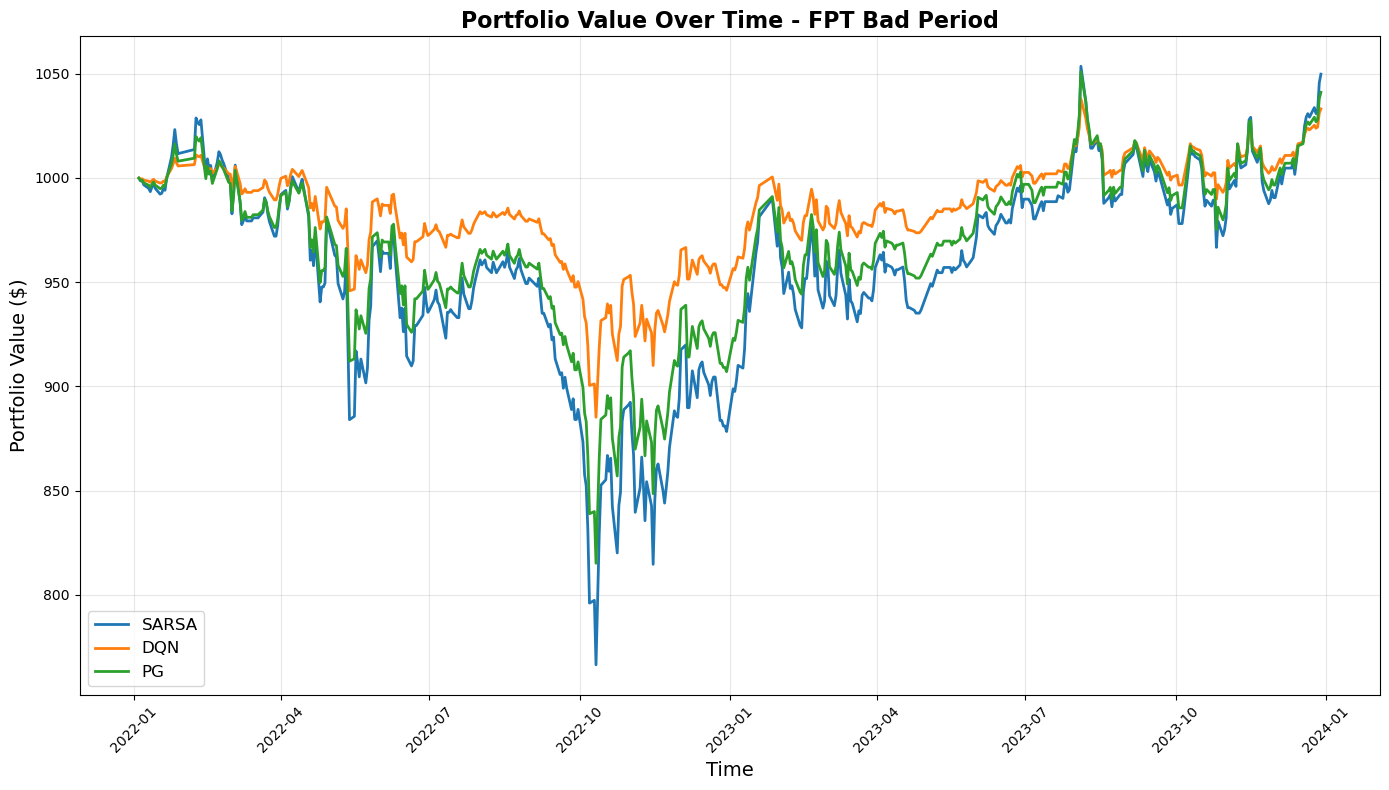

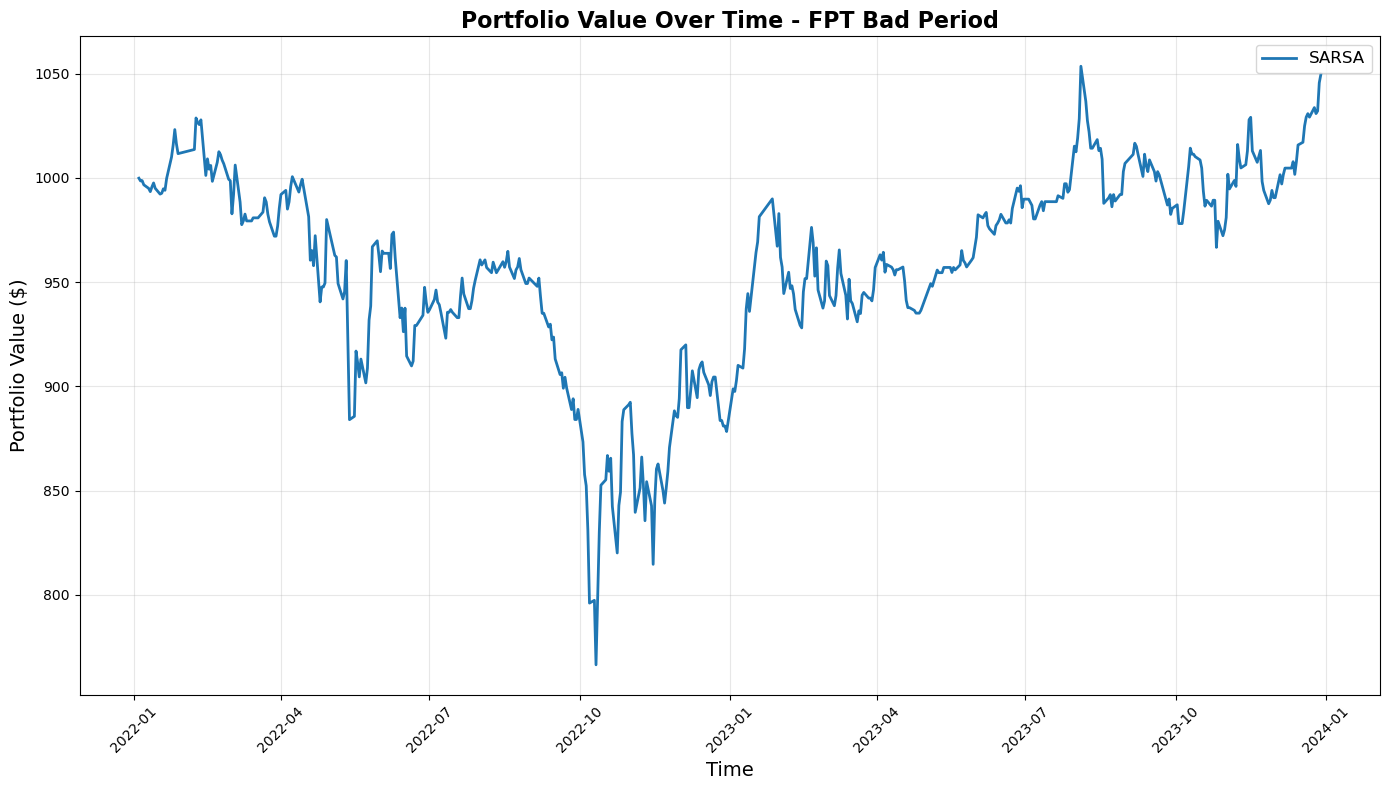

In [33]:
# Vẽ đồ thị
portfolio_histories = {}
for agent_name in ['sarsa', 'dqn', 'pg']:
    if agent_name in results:
        portfolio_histories[agent_name] = results[agent_name]['portfolio_history']

plt.figure(figsize=(14, 8))
for agent, port in portfolio_histories.items():
    # Cắt portfolio_history để khớp với len(test['time'])
    plt.plot(test['time'], port[1:], label=agent.upper(), linewidth=2)

plt.title('Portfolio Value Over Time - FPT Bad Period', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Vẽ đồ thị
portfolio_histories = {}
for agent_name in ['sarsa']:
    if agent_name in results:
        portfolio_histories[agent_name] = results[agent_name]['portfolio_history']

plt.figure(figsize=(14, 8))
for agent, port in portfolio_histories.items():
    # Cắt portfolio_history để khớp với len(test['time'])
    plt.plot(test['time'], port[1:], label=agent.upper(), linewidth=2)

plt.title('Portfolio Value Over Time - FPT Bad Period', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
import os

models_dir = r'D:\nckh\SARSA_FinancialRL\models'

os.makedirs(models_dir, exist_ok=True)

# Save trained models for FPT bad period
if 'sarsa' in results:
    torch.save(results['sarsa']['trained_agent'].state_dict(), os.path.join(models_dir, 'sarsa_bad_acb.pth'))
    print("Deep SARSA model saved.")

if 'dqn' in results:
    results['dqn']['trained_agent'].save(os.path.join(models_dir, 'dqn_bad_acb.pth'))
    print("DQN model saved.")

if 'pg' in results:
    results['pg']['trained_agent'].save_model(os.path.join(models_dir, 'pg_bad_acb.pth'))
    print("Policy Gradient model saved.")

print("All models for FPT bad period saved successfully!")

Deep SARSA model saved.
DQN model saved.
Policy Gradient model saved.
All models for FPT bad period saved successfully!


In [35]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet
import os

# Đảm bảo thư mục tồn tại
results_dir = r'D:\nckh\SARSA_FinancialRL\application\results'
os.makedirs(results_dir, exist_ok=True)

# Tạo PDF
pdf_path = os.path.join(results_dir, 'ACB_bad.pdf')
doc = SimpleDocTemplate(pdf_path, pagesize=letter)
elements = []
styles = getSampleStyleSheet()

# Title
elements.append(Paragraph("Training Results for ACBT Bad Period", styles['Title']))
elements.append(Spacer(1, 12))

# Hyperparameters
elements.append(Paragraph("Hyperparameters:", styles['Heading2']))
hp_text = f"""
Episodes: {shared_config['episodes']}
Gamma: {shared_config['gamma']}
Alpha: {shared_config['alpha']}
Epsilon Start: {shared_config['epsilon_start']}
Epsilon Min: {shared_config['epsilon_min']}
Epsilon Decay: {shared_config['epsilon_decay']}
NN Epochs: {shared_config['nn_epochs']}
NN LR: {shared_config['nn_lr']}
Enabled Agents: {shared_config['enabled_agents']}
"""
elements.append(Paragraph(hp_text, styles['Normal']))
elements.append(Spacer(1, 12))

# Results Table
elements.append(Paragraph("Training Results:", styles['Heading2']))

# Tạo data cho table
data = [['Agent', 'Average Final Profit', 'Best Profit', 'Worst Profit', 'Peak Training Profit', 'ROI', 'Annual Return Rate', 'Total Return Rate']]
for agent in agents:
    if agent in results:
        res = results[agent]
        avg_profit = f"${res['final_profit']:.2f} ± ${res['std_final_profit']:.2f}"
        best = f"${np.max(res['all_final_profits']):.2f}"
        worst = f"${np.min(res['all_final_profits']):.2f}"
        peak = f"${np.max(res['learning_curve']):.2f}" if len(res['learning_curve']) > 0 else 'N/A'
        roi = f"{res['roi']:.2f}%"
        final_portfolio = 1000 + res['final_profit']
        annual_rate, total_rate = agent_annual_return(1000, final_portfolio, start_date, end_date)
        annual = f"{annual_rate:.2f}%"
        total = f"{total_rate:.2f}%"
        data.append([res['agent'], avg_profit, best, worst, peak, roi, annual, total])

# Baseline
baseline_avg = f"${np.mean(profits):.2f} ± ${np.std(profits):.2f}"
baseline_final_portfolio = 1000 + np.mean(profits)
baseline_annual_rate, baseline_total_rate = agent_annual_return(1000, baseline_final_portfolio, start_date, end_date)
data.append(['Random Policy Baseline', baseline_avg, 'N/A', 'N/A', 'N/A', f"{((np.mean(profits)/1000)*100):.2f}%", f"{baseline_annual_rate:.2f}%", f"{baseline_total_rate:.2f}%"])

table = Table(data)
table.setStyle(TableStyle([
    ('BACKGROUND', (0,0), (-1,0), colors.grey),
    ('TEXTCOLOR', (0,0), (-1,0), colors.whitesmoke),
    ('ALIGN', (0,0), (-1,-1), 'CENTER'),
    ('FONTNAME', (0,0), (-1,0), 'Helvetica-Bold'),
    ('BOTTOMPADDING', (0,0), (-1,0), 12),
    ('BACKGROUND', (0,1), (-1,-1), colors.beige),
    ('GRID', (0,0), (-1,-1), 1, colors.black)
]))
elements.append(table)
elements.append(Spacer(1, 12))

# Biểu đồ Learning Curves
elements.append(Paragraph("Learning Curves:", styles['Heading2']))
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (agent, title) in enumerate(zip(agents, titles)):
    if agent in results:
        res = results[agent]
        mean_curve = res['learning_curve']
        axes[i].plot(mean_curve, label='Mean Profit')
        axes[i].set_title(f'{title} Learning Curve')
        axes[i].set_xlabel('Episode')
        axes[i].set_ylabel('Profit ($)')
        axes[i].legend()
        axes[i].grid(alpha=0.3)
plt.tight_layout()
learning_curve_path = os.path.join(results_dir, 'learning_curves.png')
plt.savefig(learning_curve_path)
plt.close()
elements.append(Image(learning_curve_path, width=500, height=300))

# Biểu đồ Percentiles
elements.append(Paragraph("Profit Percentiles:", styles['Heading2']))
agent_names = titles
plt.figure(figsize=(12, 8))
color_list = ['blue', 'green', 'red']
for i, (agent, name) in enumerate(zip(agents, agent_names)):
    if agent in results:
        agent_profits = results[agent]['all_final_profits']
        sorted_profits = np.sort(agent_profits)
        percentile_values = np.percentile(sorted_profits, percentile_levels)
        plt.plot(percentile_levels, percentile_values, color=color_list[i], marker='o', linestyle='-', label=name, linewidth=2, markersize=4)
plt.title('Độ biến thiên hiệu suất qua mỗi vòng lặp - FPT', fontsize=16, fontweight='bold')
plt.xlabel('Percentile (%)', fontsize=14)
plt.ylabel('Profit ($)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.xticks(percentile_levels)
plt.tight_layout()
percentile_path = os.path.join(results_dir, 'percentiles_ACB.png')
plt.savefig(percentile_path)
plt.close()
elements.append(Image(percentile_path, width=500, height=400))

# Biểu đồ Portfolio Value Over Time
elements.append(Paragraph("Portfolio Value Over Time:", styles['Heading2']))
portfolio_histories = {}
for agent_name in ['sarsa', 'dqn', 'pg']:
    if agent_name in results:
        portfolio_histories[agent_name] = results[agent_name]['portfolio_history']

plt.figure(figsize=(14, 8))
for agent, port in portfolio_histories.items():
    plt.plot(test['time'], port[1:], label=agent.upper(), linewidth=2)
plt.title('Portfolio Value Over Time - ACB Bad Period', fontsize=16, fontweight='bold')
plt.xlabel('Time', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
portfolio_path = os.path.join(results_dir, 'portfolio_value_acb_bad.png')
plt.savefig(portfolio_path)
plt.close()
elements.append(Image(portfolio_path, width=500, height=400))

# Build PDF
doc.build(elements)
print(f"PDF saved to {pdf_path}")

PDF saved to D:\nckh\SARSA_FinancialRL\application\results\ACB_bad.pdf
